# (1, λ)-σ-SA-ES
Task: Implement a multivariate variant of the (μ + λ)-σ-SA-ES and compare it on the benchmark set

In [202]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [203]:
# Step 1.1: Implement the (1+1)-ES Algorithm
def one_plus_one_es(dim, objective_function, sigma=0.01, iterations=1000, restarts=False, stagnation_threshold=100):
    # Initialize the solution randomly
    x = np.random.randn(dim)
    # Track the best solution and its objective value
    best_x = x
    best_obj = objective_function(x)
    log = np.zeros(iterations)
    stagnation_counter = 0

    for _ in range(iterations):
        # Mutate the solution
        x_mutated = x + np.random.normal(0, sigma, dim)
        # Evaluate the objective function for the mutated solution
        obj_mutated = objective_function(x_mutated)

        # Selection step: if the mutated solution is better, replace the current solution with it
        if obj_mutated < best_obj:
            x = x_mutated
            best_x = x_mutated
            best_obj = obj_mutated
            stagnation_counter = 0
        else:
            stagnation_counter += 1
        if restarts and stagnation_counter >= stagnation_threshold:
            x = np.random.randn(dim)
            stagnation_counter = 0
        log[_] = best_obj
    return best_x, best_obj, log

In [204]:
# Step 1.2: Implement the Rechenberg's 1/5 Success Rule
def rechenberg_es(dim, objective_function, sigma=0.01, iterations=1000, d=1., restarts=False, stagnation_threshold=100):
    # Initialize the solution randomly
    x = np.random.randn(dim)
    # Track the best solution and its objective value
    best_x = x
    best_obj = objective_function(x)
    log = np.zeros(iterations)
    stagnation_counter = 0

    for _ in range(iterations):
        # Mutate the solution
        x_mutated = x + np.random.normal(0, sigma, dim)
        # Evaluate the objective function for the mutated solution
        obj_mutated = objective_function(x_mutated)

        if obj_mutated <= best_obj:
            x = x_mutated
            best_x = x_mutated
            best_obj = obj_mutated
            sigma = sigma * math.e ** (4 / 5 / d)
        else:
            sigma = sigma * math.e ** (-1 / 5 / d)
            stagnation_counter += 1
        if restarts and stagnation_counter >= stagnation_threshold:
            x = np.random.randn(dim)
            stagnation_counter = 0
        log[_] = best_obj
    return best_x, best_obj, log

In [205]:
# Step 1.3: Implement the (μ + λ)-ES Algorithm
def crossover(rho, population):
    parents_indices = np.random.choice(len(population), rho, replace=False)
    return np.mean(population[parents_indices], axis=0)


def mu_plus_lambda_es(mu, lambda_, dim, objective_function, sigma=0.01, iterations=1000, rho=2):
    # Initialize the population randomly
    population = np.random.randn(mu, dim)
    # Evaluate the initial population
    fitness_values = np.array([objective_function(individual) for individual in population])
    # Track the best solution and its fitness value
    best_idx = np.argmin(fitness_values)
    best_individual = population[best_idx]
    best_fitness = fitness_values[best_idx]
    log = np.zeros(iterations)

    for generation in range(iterations):
        offspring = []
        # Generate offspring using crossover and mutation
        for _ in range(lambda_):
            base = crossover(rho, population)
            child = base + np.random.normal(0, sigma, dim)
            offspring.append(child)
        offspring = np.array(offspring)

        # Evaluate the objective function for the offspring
        offspring_fitness = np.array([objective_function(x) for x in offspring])

        # Combine parents and offspring
        combined_population = np.vstack((population, offspring))
        combined_fitness = np.concatenate((fitness_values, offspring_fitness))

        # Select the best mu individuals
        indices = np.argsort(combined_fitness)[:mu]
        population = combined_population[indices]
        fitness_values = combined_fitness[indices]

        # Update the best individual if found
        if fitness_values[0] < best_fitness:
            best_fitness = fitness_values[0]
            best_individual = population[0]

        log[generation] = best_fitness

    return best_individual, best_fitness, log


In [206]:
# Step 1.4: Implement the (1, λ)-σ-SA-ES Algorithm
def one_comma_lambda_es(dim, objective_function, lambda_=70, sigma=0.01, iterations=1000, tau=None):
    # tau is set according to the given pseudocode if not provided
    if tau is None:
        tau = 1 / np.sqrt(dim)
    
    # Initialize the solution and sigma randomly
    x = np.random.randn(dim)
    # Track the best solution and its objective value
    best_x = x
    best_obj = objective_function(x)
    best_sigma = sigma
    log = np.zeros(iterations)

    for i in range(iterations):
        offspring = []
        sigmas = []
        for _ in range(lambda_):
            # Mutate σ using a log-normal distribution
            sigma_mutated = sigma * np.exp(tau * np.random.randn())
            # Generate offspring using the mutated σ
            x_mutated = x + sigma_mutated * np.random.randn(dim)
            obj_mutated = objective_function(x_mutated)
            offspring.append((x_mutated, obj_mutated))
            sigmas.append(sigma_mutated)
        # Select the best offspring based on the objective value
        best_index = np.argmin([obj for _, obj in offspring])
        best_offspring = offspring[best_index][0]
        best_offspring_obj = offspring[best_index][1]
        best_offspring_sigma = sigmas[best_index]

        # Update the best solution found so far
        if best_offspring_obj < best_obj:
            best_x = best_offspring
            best_obj = best_offspring_obj
            best_sigma = best_offspring_sigma
            x = best_offspring
            sigma = best_offspring_sigma

        log[i] = best_obj

    return best_x, best_sigma, log

In [207]:
# Step 1.5: multivariate variant of the (μ + λ)-σ-SA-ES
def mu_plus_lambda_multivariate_es(dim, objective_function, mu=10, lambda_=70, sigma=0.01, iterations=1000, tau=None):
    if tau is None:
        tau = 1 / np.sqrt(2 * np.sqrt(dim))
    
    # Initialize a population of mu parents
    parents = np.random.randn(mu, dim)
    parent_sigmas = np.full((mu, dim), sigma)
    parent_fitness = np.array([objective_function(ind) for ind in parents])
    
    log_objective = np.zeros(iterations)
    log_sigma = np.zeros((iterations, dim))
    
    for i in range(iterations):
        offspring = []
        offspring_sigmas = []
        for _ in range(lambda_):
            # Select parent for offspring
            parent_idx = np.random.randint(mu)
            parent = parents[parent_idx]
            parent_sigma = parent_sigmas[parent_idx]
            
            # Mutate σ using a log-normal distribution
            sigma_mutated = parent_sigma * np.exp(tau * np.random.randn(dim))
            # Generate offspring using the mutated σ
            x_mutated = parent + sigma_mutated * np.random.randn(dim)
            obj_mutated = objective_function(x_mutated)
            
            offspring.append(x_mutated)
            offspring_sigmas.append(sigma_mutated)
        
        # Evaluate fitness of offspring
        offspring_fitness = np.array([objective_function(ind) for ind in offspring])
        
        # Combine parents and offspring
        total_population = np.vstack((parents, offspring))
        total_sigmas = np.vstack((parent_sigmas, offspring_sigmas))
        total_fitness = np.concatenate((parent_fitness, offspring_fitness))
        
        # Select the next generation
        next_gen_indices = np.argsort(total_fitness)[:mu]
        parents = total_population[next_gen_indices]
        parent_sigmas = total_sigmas[next_gen_indices]
        parent_fitness = total_fitness[next_gen_indices]
        
        log_objective[i] = parent_fitness[0]
        log_sigma[i] = parent_sigmas[0]

    best_index = np.argmin(parent_fitness)
    return parents[best_index], parent_sigmas[best_index], log_objective, log_sigma

In [208]:
# Step 2: Define Benchmark Functions
def sphere_function(x):
    return np.sum(x ** 2)

def rosenbrock_function(x):
    return np.sum(100 * (x[1:] - x[:-1] ** 2) ** 2 + (1 - x[:-1]) ** 2)

def rastrigin_function(x):
    return 10 * len(x) + np.sum(x ** 2 - 10 * np.cos(2 * np.pi * x))

In [209]:
# Experiment Parameters
dimensions = [2, 5, 10, 20]
repetitions = 1
iterations = 1000
sigma = 0.01
mu = 10
lambda_ = 70
results = {}
fitness_logs = {}
fitness_sigma_logs = {}

# Step 3: Experiment Setup
for dim in dimensions:
    results[dim] = {
        'Sphere': {'rechenberg_es': [], 'one_plus_one_es': [], 'one_plus_one_restarts_es': [], 'mu_plus_lambda_es': [], 'one_comma_lambda_es': [], 'mu_plus_lambda_multivariate_es': []},
        'Rastrigin': {'rechenberg_es': [], 'one_plus_one_es': [], 'one_plus_one_restarts_es': [], 'mu_plus_lambda_es': [], 'one_comma_lambda_es': [], 'mu_plus_lambda_multivariate_es': []},
        'Rosenbrock': {'rechenberg_es': [], 'one_plus_one_es': [], 'one_plus_one_restarts_es': [], 'mu_plus_lambda_es': [], 'one_comma_lambda_es': [], 'mu_plus_lambda_multivariate_es': []}
    }
    fitness_logs[dim] = {
        'Sphere': {'rechenberg_es': [], 'one_plus_one_es': [], 'one_plus_one_restarts_es': [], 'mu_plus_lambda_es': [], 'one_comma_lambda_es': [], 'mu_plus_lambda_multivariate_es': []},
        'Rastrigin': {'rechenberg_es': [], 'one_plus_one_es': [], 'one_plus_one_restarts_es': [], 'mu_plus_lambda_es': [], 'one_comma_lambda_es': [], 'mu_plus_lambda_multivariate_es': []},
        'Rosenbrock': {'rechenberg_es': [], 'one_plus_one_es': [], 'one_plus_one_restarts_es': [], 'mu_plus_lambda_es': [], 'one_comma_lambda_es': [], 'mu_plus_lambda_multivariate_es': []}
    }
    fitness_sigma_logs[dim] = {
        'Sphere': {'rechenberg_es': [], 'one_plus_one_es': [], 'one_plus_one_restarts_es': [], 'mu_plus_lambda_es': [], 'one_comma_lambda_es': [], 'mu_plus_lambda_multivariate_es': []},
        'Rastrigin': {'rechenberg_es': [], 'one_plus_one_es': [], 'one_plus_one_restarts_es': [], 'mu_plus_lambda_es': [], 'one_comma_lambda_es': [], 'mu_plus_lambda_multivariate_es': []},
        'Rosenbrock': {'rechenberg_es': [], 'one_plus_one_es': [], 'one_plus_one_restarts_es': [], 'mu_plus_lambda_es': [], 'one_comma_lambda_es': [], 'mu_plus_lambda_multivariate_es': []}
    }
    for _ in range(repetitions):
        _, obj_sphere, log_objective, log_sigma = mu_plus_lambda_multivariate_es(dim=dim, mu=mu, objective_function=sphere_function, lambda_=lambda_, sigma=sigma, iterations=iterations)
        results[dim]['Sphere']['mu_plus_lambda_multivariate_es'].append(obj_sphere)
        fitness_logs[dim]['Sphere']['mu_plus_lambda_multivariate_es'].append(log_objective)
        fitness_sigma_logs[dim]['Sphere']['mu_plus_lambda_multivariate_es'].append(log_sigma)
                
        _, obj_sphere, log_objective, log_sigma = mu_plus_lambda_multivariate_es(dim=dim, mu=mu, objective_function=sphere_function, lambda_=lambda_, sigma=sigma, iterations=iterations)
        results[dim]['Rastrigin']['mu_plus_lambda_multivariate_es'].append(obj_sphere)
        fitness_logs[dim]['Rastrigin']['mu_plus_lambda_multivariate_es'].append(log_objective)
        fitness_sigma_logs[dim]['Rastrigin']['mu_plus_lambda_multivariate_es'].append(log_sigma)
        
        _, obj_sphere, log_objective, log_sigma = mu_plus_lambda_multivariate_es(dim=dim, mu=mu, objective_function=rosenbrock_function, lambda_=lambda_, sigma=sigma, iterations=iterations)
        results[dim]['Rosenbrock']['mu_plus_lambda_multivariate_es'].append(obj_sphere)
        fitness_logs[dim]['Rosenbrock']['mu_plus_lambda_multivariate_es'].append(log_objective)
        fitness_sigma_logs[dim]['Rosenbrock']['mu_plus_lambda_multivariate_es'].append(log_sigma)
        
        '''
        _, obj_sphere, log_sphere = one_comma_lambda_es(dim=dim, objective_function=sphere_function, lambda_=lambda_, sigma=sigma, iterations=iterations)
        results[dim]['Sphere']['one_comma_lambda_es'].append(obj_sphere)
        fitness_logs[dim]['Sphere']['one_comma_lambda_es'].append(log_sphere)
        
        _, obj_sphere, log_sphere = one_comma_lambda_es(dim=dim, objective_function=sphere_function, lambda_=lambda_, sigma=sigma, iterations=iterations)
        results[dim]['Rastrigin']['one_comma_lambda_es'].append(obj_sphere)
        fitness_logs[dim]['Rastrigin']['one_comma_lambda_es'].append(log_sphere)
        
        _, obj_sphere, log_sphere = one_comma_lambda_es(dim=dim, objective_function=rosenbrock_function, lambda_=lambda_, sigma=sigma, iterations=iterations)
        results[dim]['Rosenbrock']['one_comma_lambda_es'].append(obj_sphere)
        fitness_logs[dim]['Rosenbrock']['one_comma_lambda_es'].append(log_sphere)
        
        _, obj_sphere, log_sphere = mu_plus_lambda_es(mu, lambda_, dim, sphere_function, sigma, iterations)
        results[dim]['Sphere']['mu_plus_lambda_es'].append(obj_sphere)
        fitness_logs[dim]['Sphere']['mu_plus_lambda_es'].append(log_sphere)

        _, obj_sphere, log_sphere = rechenberg_es(dim, sphere_function, sigma, iterations)
        results[dim]['Sphere']['rechenberg_es'].append(obj_sphere)
        fitness_logs[dim]['Sphere']['rechenberg_es'].append(log_sphere)

        _, obj_sphere, log_sphere = one_plus_one_es(dim, sphere_function, sigma, iterations, restarts=False)
        results[dim]['Sphere']['one_plus_one_es'].append(obj_sphere)
        fitness_logs[dim]['Sphere']['one_plus_one_es'].append(log_sphere)

        _, obj_sphere, log_sphere = one_plus_one_es(dim, sphere_function, sigma, iterations, restarts=True)
        results[dim]['Sphere']['one_plus_one_restarts_es'].append(obj_sphere)
        fitness_logs[dim]['Sphere']['one_plus_one_restarts_es'].append(log_sphere)

        # Rastrigin Function
        _, obj_rastrigin, log_rastrigin = mu_plus_lambda_es(mu, lambda_, dim, rastrigin_function, sigma, iterations)
        results[dim]['Rastrigin']['mu_plus_lambda_es'].append(obj_rastrigin)
        fitness_logs[dim]['Rastrigin']['mu_plus_lambda_es'].append(log_rastrigin)
        
        _, obj_rastrigin, log_rastrigin = rechenberg_es(dim, rastrigin_function, sigma, iterations)
        results[dim]['Rastrigin']['rechenberg_es'].append(obj_rastrigin)
        fitness_logs[dim]['Rastrigin']['rechenberg_es'].append(log_rastrigin)

        _, obj_rastrigin, log_rastrigin = one_plus_one_es(dim, rastrigin_function, sigma, iterations)
        results[dim]['Rastrigin']['one_plus_one_es'].append(obj_rastrigin)
        fitness_logs[dim]['Rastrigin']['one_plus_one_es'].append(log_rastrigin)
        
        _, obj_sphere, log_sphere = one_plus_one_es(dim, rastrigin_function, sigma, iterations, restarts=True)
        results[dim]['Rastrigin']['one_plus_one_restarts_es'].append(obj_sphere)
        fitness_logs[dim]['Rastrigin']['one_plus_one_restarts_es'].append(log_sphere)
        '''
        

# Display initial 5 results
# results[dim]['Sphere'][:5], results[dim]['Rastrigin'][:5]
# fitness_logs[dim]['Sphere'][:5], fitness_logs[dim]['Rastrigin'][:5]

In [210]:
def plot_average_fitness_progression(logs, dimensions, fittype='Sphere', log=False):
    plt.figure(figsize=(12, 8))

    for dim in dimensions:
        #for func in ['rechenberg_es', 'one_plus_one_es', 'one_plus_one_restarts_es', 'mu_plus_lambda_es', 'one_comma_lambda_es']:
        for func in ['mu_plus_lambda_multivariate_es']:
            # Calculate the mean fitness progression for each dimension and function
            mean_progression = np.mean(logs[dim][fittype][func], axis=0)
            plt.plot(mean_progression, label=f'Dimension {dim}, Function {func}')

    plt.xlabel('Iteration')
    plt.ylabel('Average Fitness Value')
    if log:
        plt.yscale('log')
    plt.title(f'Average {fittype} Fitness Progression Over Iterations for Different Dimensions and Functions')
    plt.legend()
    plt.grid(True)
    plt.show()

In [211]:
# Compare the function Rosenbrock, Rastrigin and Sphere in one plot
def plot_comparison(fitness_logs, dimensions, fitness_function, log=False):
    plt.figure(figsize=(12, 8))

    for dim in dimensions:
        for func in ['Sphere', 'Rastrigin', 'Rosenbrock']:
        #for func in ['Sphere', 'Rastrigin']:
            mean_progression = np.mean(fitness_logs[dim][func][fitness_function], axis=0)
            plt.plot(mean_progression, label=f'{func} Dimension {dim}')

    plt.xlabel('Iteration')
    plt.ylabel('Average Fitness Value')
    plt.title('Comparison of Sphere, Rastrigin, and Rosenbrock Functions Over Iterations for Different Dimensions')
    plt.legend()
    if log:
        plt.yscale('log')
    plt.grid(True)
    plt.show()

In [212]:
# visualize the step size
def plot_step_size_progression(sigmas, dimensions):
    plt.figure(figsize=(12, 6))
    
    for dim in dimensions:
        for func in ['Sphere', 'Rastrigin', 'Rosenbrock']:
            mean_progression = np.mean(sigmas[dim][func][func], axis=0)
            plt.plot(mean_progression, label=f'{func} Dimension {dim}')
            #plt.plot(sigmas[dim][func]['mu_plus_lambda_multivariate_es'], label=f'Step size for dim {dim}')
    
    plt.title('Step Size Evolution Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Step Size')
    plt.legend()
    plt.show()

In [213]:
#plot_step_size_progression(fitness_sigma_logs, dimensions)

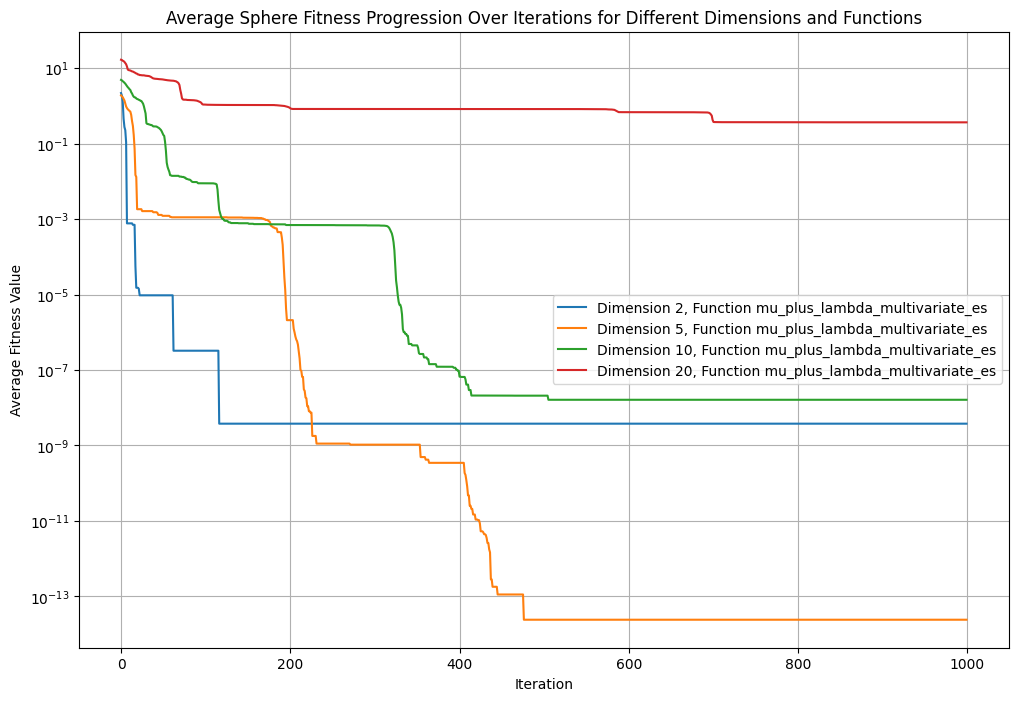

In [214]:
plot_average_fitness_progression(fitness_logs, dimensions, fittype='Sphere', log=True)

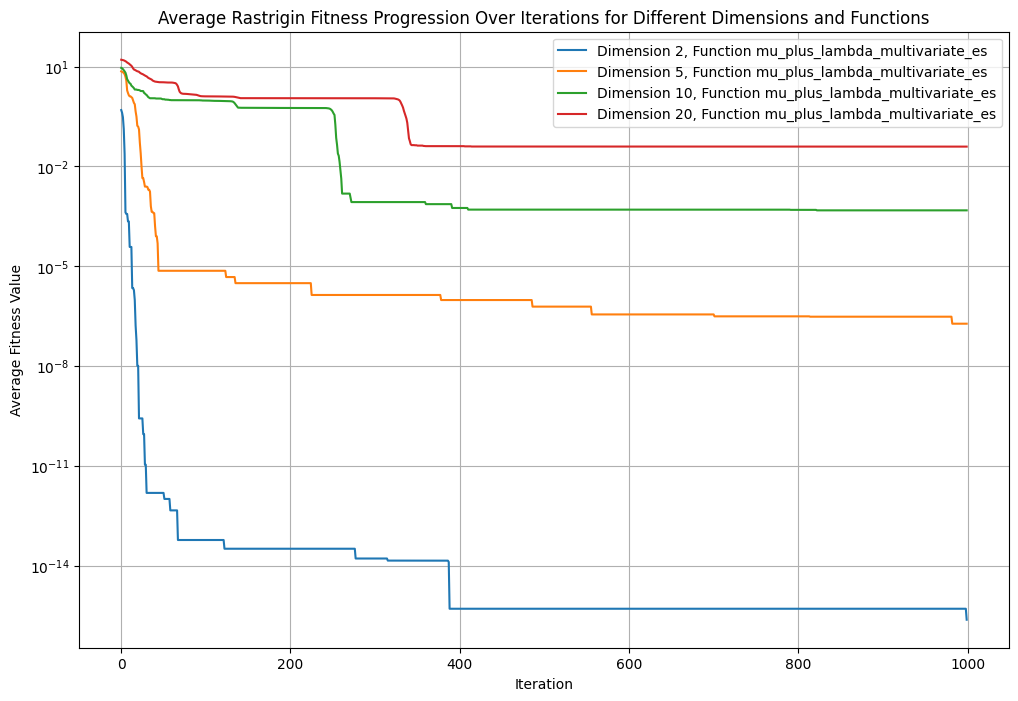

In [215]:
plot_average_fitness_progression(fitness_logs, dimensions, fittype='Rastrigin', log=True)

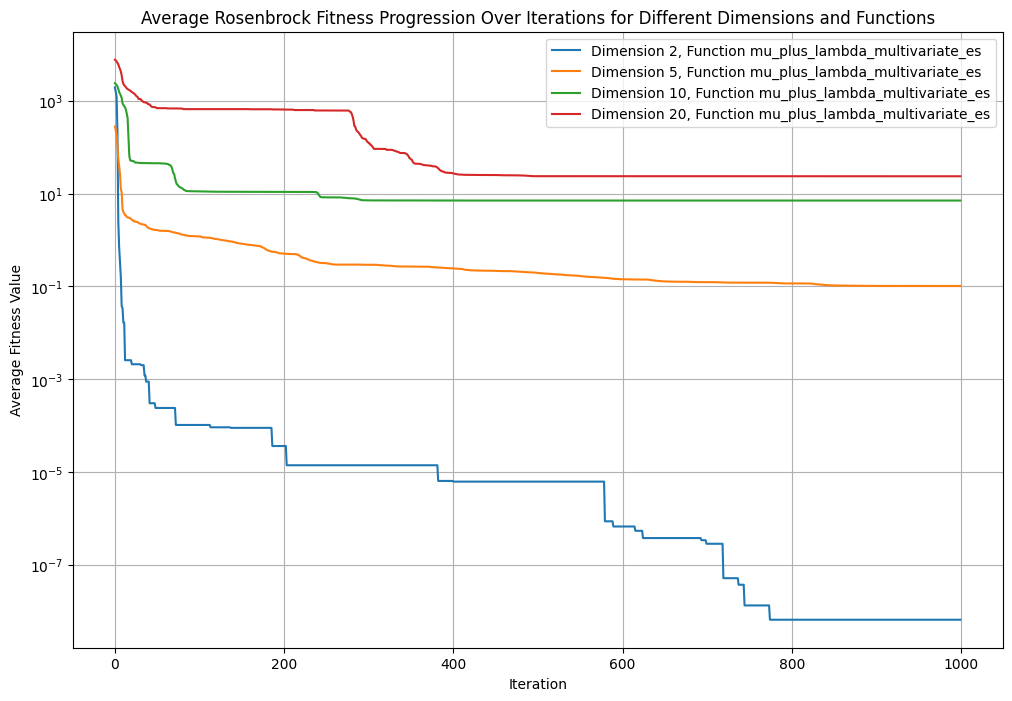

In [216]:
plot_average_fitness_progression(fitness_logs, dimensions, fittype='Rosenbrock', log=True)

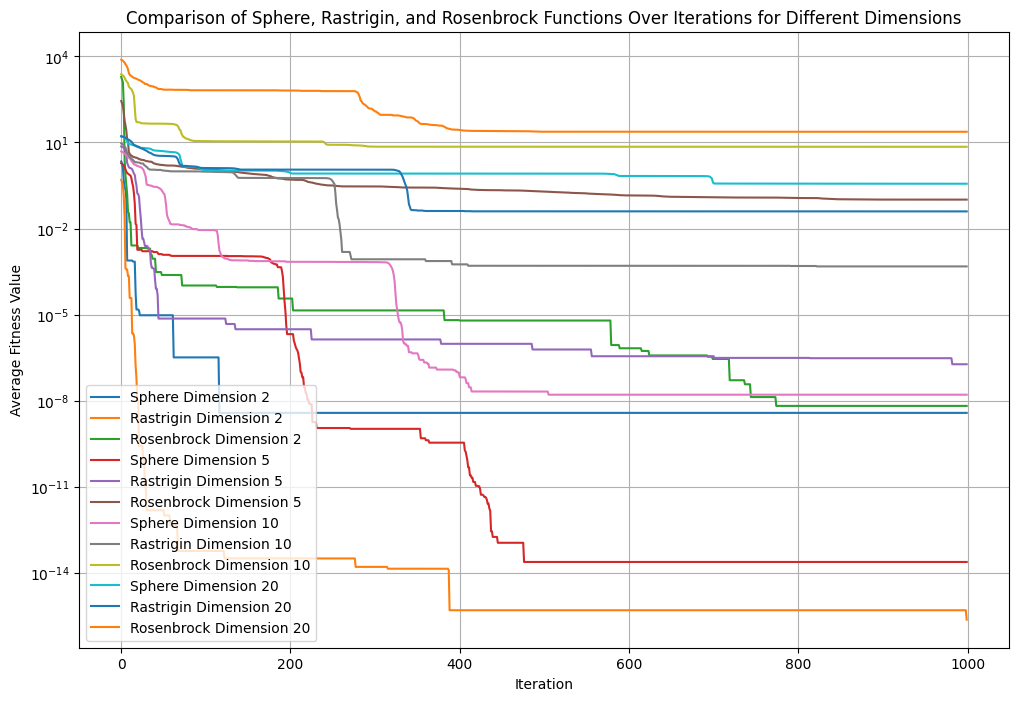

In [217]:
plot_comparison(fitness_logs, dimensions, fitness_function='mu_plus_lambda_multivariate_es', log=True)